# **Reinforcement Learning (COMP-767) Assignment 2 - Question -1**
## Student 1:
## Name: Bhavya Patwa
### McGill ID: 260964036
### email ID: bhavya.patwa@mail.mcgill.ca
## Student 2:
## Name: Yifan Bai
### McGill ID: 260562421
### email ID: yifan.bai@mail.mcgill.ca

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
# Environment for running TD-Lambda experiments
class Environment():
  def __init__(self):
    self.current_state = 0.5
    self.terminal_states = [0,1]
    self.take_step = lambda: np.random.uniform(low=-0.2,high=0.2)
    self.gamma = 1 # discount rate

  # st = state
  def get_reward(self,st):
    if st < 0 or st > 1:
      return st
    else:
      return 0
  
  # builds sparse state space using tilings
  def build_sparse_state_space(self):
    interval_length = (self.terminal_states[1] - self.terminal_states[0])/10
    
    intervals = np.linspace(0 - interval_length / 2, 1 + interval_length / 2, num=11).reshape(1,-1)
    self.intervals = np.repeat(intervals,10,axis=0)
    # print("intervals.shape",intervals.shape,intervals[0])
    
    self.offsets = interval_length/np.random.randint(2,high=10,size=10)*np.random.choice([-1,1],size=10)
    self.offsets = self.offsets.reshape(-1,1)
    self.tilings = self.offsets + self.intervals
    
    # print(self.tilings)
    # print(self.offsets.shape,self.offsets)

  # returns binary features encoded over all tilings given a state
  def get_sparse_feature(self,st):
    feature_vector = []
    for i in range(10):
      loc = 0
      left = np.argmin(st >= self.tilings[i]) - 1
      right = np.argmax(st < self.tilings[i])
      encoding = np.zeros(10)
      # print("left:",left,"right:",right)
      if left < right:
        encoding[left] = 1
      else: # this should never get printed or else error
        print("Something is wrong")
      feature_vector.append(encoding)
    feature_vector = np.reshape(feature_vector,-1)
    return feature_vector

  # runs the td lambda over N-iter seeds and 25 episodes for each seed
  def td_lambda(self,alpha,lambda_,n_iter=50):

    self.alpha = alpha
    self.lambda_ = lambda_
    outputs = []
    for i in range(n_iter):
      np.random.seed(i)
      self.w = np.zeros((1,100))
      # 25 episodes
      for j in range(25):
        self.run_one_episode()
      val = np.linspace(0,1,num=21)
      # MSVE
      msve = np.sqrt(np.mean(np.square([(self.get_value(self.get_sparse_feature(x)) - x) for x in val])))
      outputs.append(msve)
    return outputs

  # iterates through a single episode until it reaches terminal state
  def run_one_episode(self):
    self.current_state = 0.5
    z = np.zeros((1,100))
    no_break = True
    while no_break:
      A = self.take_step()
      S_prime = self.current_state + A
      if S_prime < 0 or S_prime > 1:
        no_break = False

      R = self.get_reward(S_prime)
      x_t = self.get_sparse_feature(self.current_state)
      x_t_prime = self.get_sparse_feature(S_prime)
      delta_v_S_w = x_t

      z = self.gamma *self.lambda_ * z + delta_v_S_w
      if no_break:
        delta = R + self.gamma * self.get_value(x_t_prime) - self.get_value(x_t)
      else:
        delta = R
      # print("delta:",delta.shape)
      self.w += self.alpha * delta * z
      # print("w:",self.w.shape)
      # print("z:",z.shape)
      self.current_state = S_prime

  # value function  
  def get_value(self,x):
    w = self.w.reshape(-1,1)
    S = x.reshape(1,-1)
    v_hat_S_w = np.dot(S,w)
    # print("value:",v_hat_S_w)
    return v_hat_S_w[0][0]


In [ ]:
# np.eye(10)[np.digitize(0.25, a)]

In [ ]:
env = Environment()
env.build_sparse_state_space()

In [ ]:
alpha = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
lambda_ = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]


In [ ]:
# runs through all alphas for a single lambda
def run_for_lambda(l):
  Y = []
  stds = []
  for a in alpha:
    # dividing a by 10 since n tilings = 10
    # NOTE: dividing by 50 INSTEAD of 10 to get good results (like in the textbook)
    msve = env.td_lambda(a/50, l,n_iter=50)
    std = np.std(msve)
    y = np.mean(msve)
    Y.append(y)
    stds.append(std)
  return Y,stds

In [ ]:
results = {}
for i in tqdm(lambda_):
  y,stds = run_for_lambda(i)
  results[i] = [y,stds]


100%|██████████| 11/11 [15:34<00:00, 85.60s/it]


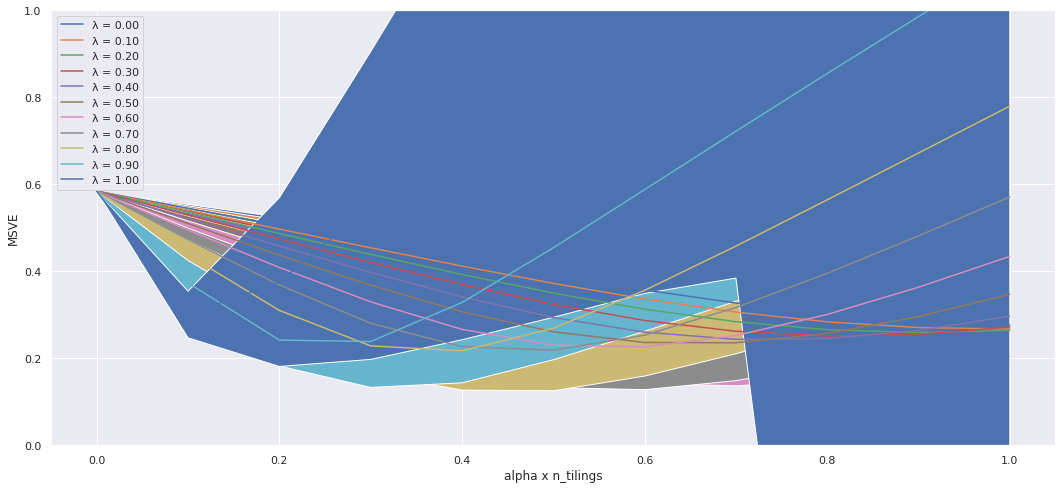

In [ ]:
# alpha/50
sns.set(rc={'figure.figsize':(18,8)})
# palette = sns.color_palette("Paired")
for l in lambda_:
  ax = sns.lineplot(x=alpha,y=results[l][0],label="λ = %0.2f"%l)
  # ax.errorbar(alpha,results[l][0],yerr=results[l][1])
  y = np.array(results[l][0])
  yerr = np.array(results[l][1])
  plt.fill_between(alpha, y-yerr, y+yerr) # stderr
  plt.xlabel("alpha x n_tilings")
  plt.ylabel("MSVE")
  plt.ylim(0,1)

Observations:

All the states start with a constant MVSE value of 0.58. We can observe from the curves that for higher values of lambda (>0.8), it shoots up the MVSE incredibly fast even for lower $\alpha$'s.  

As mentioned in the textbook, one must divide their alpha will $n$ (no. of tilings i.e. 10) and while I do so, it only smoothens out for $n$ closer to 20 or 50 rather than 10 when dividing $\alpha$.

RMSE is incredibly unstable for lambda=1